In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor



def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        batch_size=128,
    )
    return agent

In [19]:
#learning   
l = .5
step = 200000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mae"], action_lr=0.001, tau_lr=0.0001)
a.actor = make_standup_agent(a.actor, .01, env, epochs=50, verbose=False)
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 179s 18ms/step - reward: -1.8511
1 episodes - episode_reward: -18511.077 [-18511.077, -18511.077] - loss: 0.028 - mean_absolute_error: 0.106 - mean_q: -0.724

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 198s 20ms/step - reward: -1.9865
Interval 3 (20000 steps performed)
 4715/10000 [=============>................] - ETA: 1:43 - reward: -9.5667done, took 468.627 seconds


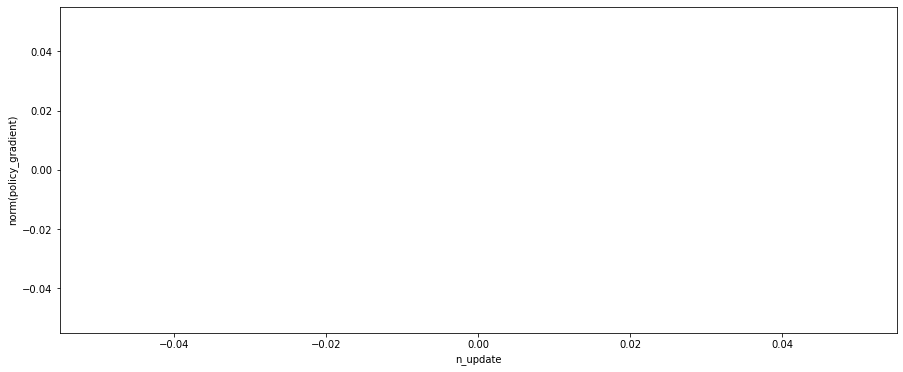

In [16]:
# gradient changing log
grads = np.array(a.gradient_log)
ma = moving_average(grads, 1000)
plt.figure(figsize=(15,6))
plt.plot(range(grads.shape[0]),grads)
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

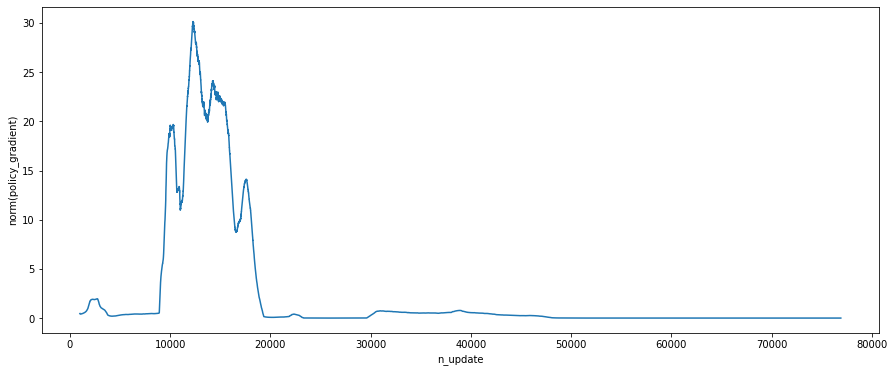

In [62]:
# moving average
plt.figure(figsize=(15,6))
plt.plot(range(1000,grads.shape[0]), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

In [9]:
#learning   
l = .5
step = 200000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mae"], action_lr=0.001, tau_lr=0.0001)
a.actor.load_weights('../tmp.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 200000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 135s 14ms/step - reward: -1.2082
3 episodes - episode_reward: -33.914 [-97.329, 7.920] - loss: 0.005 - mean_absolute_error: 0.058 - mean_q: -3.324

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 161s 16ms/step - reward: -10.7136
1 episodes - episode_reward: -119111.785 [-119111.785, -119111.785] - loss: 0.249 - mean_absolute_error: 0.349 - mean_q: -46.381

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 147s 15ms/step - reward: -0.9390
Interval 4 (30000 steps performed)
10000/10000 [==============================] - 152s 15ms/step - reward: -9.5166
1 episodes - episode_reward: -104551.285 [-104551.285, -104551.285] - loss: 4.011 - mean_absolute_error: 0.579 - mean_q: -129.164

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 208s 21ms/step - reward: -2.6135
Interval 6 (50000 step

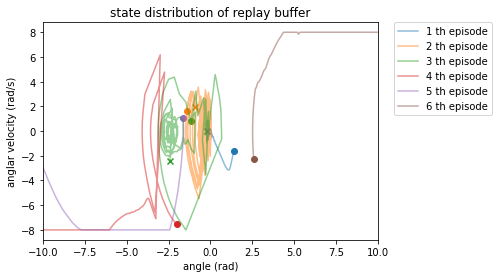

In [18]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(a.state_memory):
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i])
    plt.plot(em[:,0], em[:,1], color=cycle[i], label=f'{i+1} th episode', alpha=0.5)
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of replay buffer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(-10, 10)
plt.show()

In [43]:
# 学習せずにインタラクションだけを繰り返す

states = []
for _ in range(10):
    env.reset()
    episode_memory = []
    time_limit = 10
    # taus = []
    acc_time = 0
    while True:
        reward = 0
        x = env.state
        episode_memory.append(x)
        a_agent, tau = a.forward(x)
        acc_time += tau
        action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        # print(tau, dt, action_repetition)
        for p in range(action_repetition):
            _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        if acc_time > time_limit:
            break
    states.append(np.array(episode_memory))

KeyboardInterrupt: 

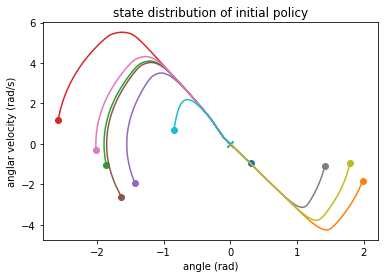

In [35]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(states):
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i])
    plt.plot(em[:,0], em[:,1], color=cycle[i])
    #plt.scatter(em[-1,0], em[-1,1], marker='x')
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of initial policy')
plt.show()

(4399,)
(4399,)


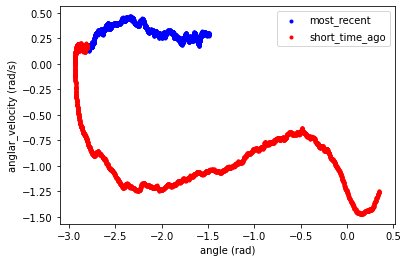

In [5]:
states = []
indices = np.array(range(45600,49999))
print(indices.shape)
for e in a.memory.sample(len(indices), batch_idxs=indices):
    states.append(e.state0[0])
states = np.array(states)
plt.scatter(states[:,0], states[:,1], color='blue', marker='.', label='most_recent')

states = []
indices = np.array(range(41200,45599))
print(indices.shape)
for e in a.memory.sample(len(indices), batch_idxs=indices):
    states.append(e.state0[0])
states = np.array(states)
plt.scatter(states[:,0], states[:,1], color='red', marker='.', label='short_time_ago')

plt.xlabel('angle (rad)')
plt.ylabel('anglar_velocity (rad/s)')
plt.legend()
plt.show()
# 急に+∞のmemoryが増えちゃった = ρπの破滅

(9998,)


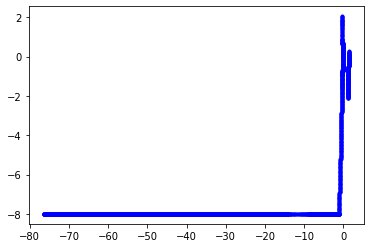

In [20]:
states = []
indices = np.array(range(1,9999))
print(indices.shape)
for e in a.memory.sample(len(indices), batch_idxs=indices):
    states.append(e.state0[0])
states = np.array(states)
plt.scatter(states[:,0], states[:,1], color='blue', marker='.', label='most_recent')


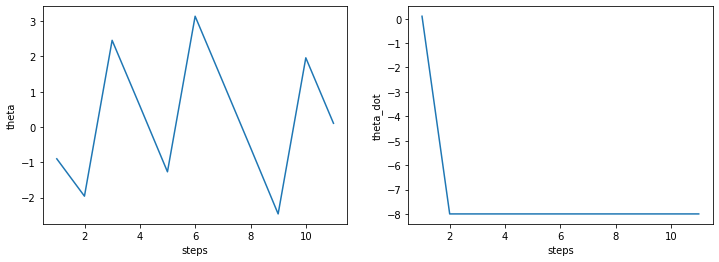

In [75]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 5.
env.reset()
env.set_state(np.array([-0.9, 0.1]))
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

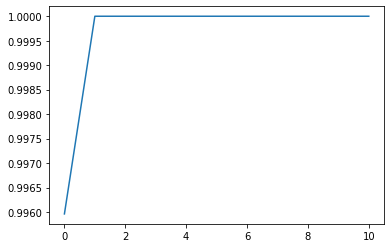

In [76]:
plt.plot(taus)

In [1]:
states = []
taus = []
high = np.array([np.pi, 8])
for _ in range(500):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = a.forward(x)
    taus.append(action[1])
states = np.array(states)

NameError: name 'np' is not defined

In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

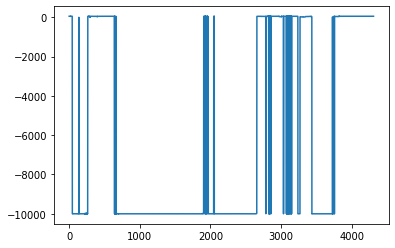

In [28]:
plt.plot(out.history['episode_reward'])

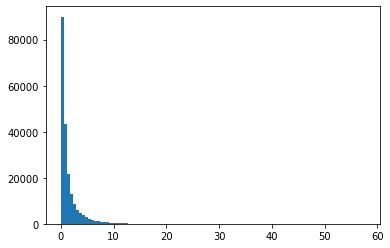

In [31]:
plt.hist(grads, bins=100)
plt.show()

In [37]:
mem = a.memory.sample(50000)
states = []
actions = []
for m in mem:
    states.append(m.state0[0])
    actions.append(m.action)
states = np.array(states)
actions = np.array(actions)

In [25]:
actor = branch_actor((2,),(2,))

In [13]:
memory = []
l = 5.
for i in range(5000):
    env.reset()
    state0 = env.state
    a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
    memory.append([state0[0], state0[1], tau])
memory = np.array(memory)

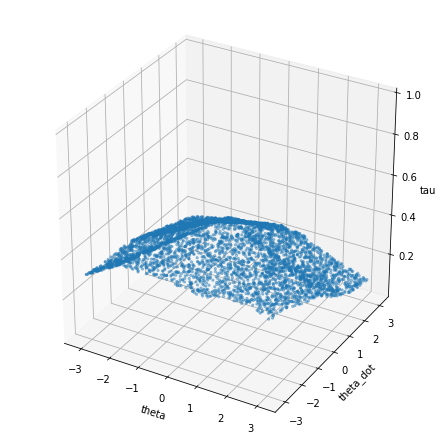

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,1.0)

ax.scatter3D(memory[:,0], memory[:,1], memory[:,2], marker='.', alpha=0.4)

In [16]:
from util import make_standup_agent
actor = make_standup_agent(actor, 0.01, env, verbose=True)


Epoch 1/50
30000/30000 [==============================] - 1s 34us/step - loss: 3.0028
Epoch 2/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.1366
Epoch 3/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0697
Epoch 4/50
30000/30000 [==============================] - 0s 16us/step - loss: 0.0600: 0s - loss
Epoch 5/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0565
Epoch 6/50
30000/30000 [==============================] - 0s 16us/step - loss: 0.0543
Epoch 7/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0520
Epoch 8/50
30000/30000 [==============================] - 0s 16us/step - loss: 0.0500
Epoch 9/50
30000/30000 [==============================] - 1s 17us/step - loss: 0.0480
Epoch 10/50
30000/30000 [==============================] - 0s 17us/step - loss: 0.0468
Epoch 11/50
30000/30000 [==============================] - 1s 20us/step - loss: 0.0454
Epoch 12/50
30000/30000 [===============

In [41]:
memory = []
l = 5.
ma = np.array([50.,50.])
for i in range(5000):
    state0 = np.random.uniform(low=-ma, high=ma)
    a_agent, tau = a.actor.predict_on_batch(np.array([[state0]]))[0]
    memory.append([state0[0], state0[1], tau])
memory = np.array(memory)

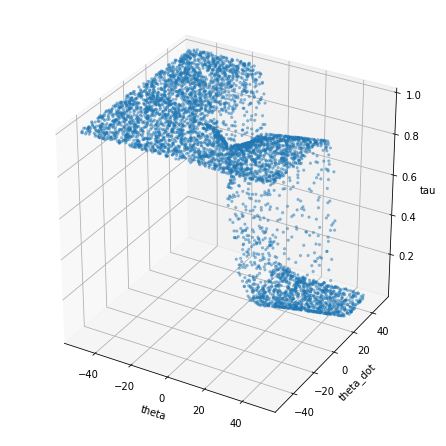

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,1.0)

ax.scatter3D(memory[:,0], memory[:,1], memory[:,2], marker='.', alpha=0.4)

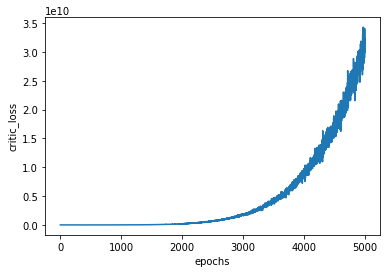

In [5]:

critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
epoch = 5000
gamma = 0.99
arr = np.array(range(a.memory.nb_entries))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = a.memory.sample(a.batch_size)
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append(m[0])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append(m[3])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = a.actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    r_second = gamma * critic.predict_on_batch(state1_batch_with_action)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [81]:
b = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=0.00001, clipnorm=1.), Adam(lr=0.001, clipnorm=1.)
optimizer = [actor_optimizer, critic_optimizer]
b.compile(optimizer=optimizer, metrics=["mae"], action_lr=0.0001, tau_lr=0.001)
b.actor = make_standup_agent(b.actor, .01, env, verbose=False)

In [83]:
high = np.pi*np.ones(2,)
for _ in range(10):
    x = np.random.uniform(low=-high, high=high)
    print(a.forward(x))
    print(b.forward(x))
    print()

[-9.999739    0.99985254]
[7.5273170e+00 1.1540558e-03]

[-9.9993334e+00  1.6408312e-03]
[-9.9987640e+00  1.0019746e-03]

[-9.996586   0.9999012]
[-9.9658031e+00  1.3005352e-03]

[-9.979913  0.992833]
[-4.9645996   0.00899488]

[-9.997153    0.98591346]
[-9.9988823e+00  1.4370666e-03]

[-9.986576   0.9879084]
[8.350636e+00 7.411491e-03]

[-9.990459   0.9998548]
[-9.8650093e+00  1.0889925e-03]

[-9.999501   0.9999189]
[9.9987040e+00 1.0350916e-03]

[-9.9999485   0.99451745]
[9.9657211e+00 3.3374643e-03]

[-9.999114   0.9999795]
[9.9980927e+00 1.0244658e-03]



In [84]:
ap = NN_params(a.actor)
bp = NN_params(b.actor)
dif = bp - ap

In [129]:
b.actor = make_standup_agent(b.actor, 1., env, verbose=False)

In [130]:
high = np.pi*np.ones(2,)
for _ in range(10):
    x = np.random.uniform(low=-high, high=high)
    print(b.forward(x))

    print()

[9.999999  0.9999999]

[10.  1.]

[-9.955486   0.9999957]

[-9.993748   0.9999999]

[9.999975  0.9999995]

[-8.448686    0.99998426]

[-9.999074    0.99999976]

[-9.894086  1.      ]

[10.  1.]

[10.          0.99999976]



In [136]:
b.original_noise
b.training

with b.training = True:
    x = np.random.uniform(low=-high, high=high)
    b.forward(x)

SyntaxError: invalid syntax (<ipython-input-136-b0bb18ebf488>, line 4)